# Fine-tuning an image classification model on a skin lesions dataset
[tutorial1](https://keras.io/guides/transfer_learning), [tutorial2](https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras)

A concrete end-to-end transfer learning example. We will load a SOTA model, pre-trained on ImageNet, and use it on the skin lesions classification dataset.

<br>

<center><img src="images/Diagram of the methods developed for skin lesion images classification.png", alt="Ensemble"/></center>

In [1]:
!nvidia-smi

Tue May 16 12:37:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
config = {
    "model_name": "VGG19",  # ResNet50, Xception, InceptionResNetV2, VGG19
    "color_mode": "rgb",  # rgb, grayscale,
    "train_model": True,
    "to_unzip": True,
    "with_augmentations": True,
    "localization": "",  # "", "back", "abdomen", "lower extremity", "upper extremity"
}

In [3]:
def connect_to_resources():
    try:
        from google.colab import drive, files

        drive.mount('/content/drive')
        print('Running on COLAB')
        return '/content/drive/MyDrive/final_project'
    except ModuleNotFoundError:
        print('Not running on COLAB')
        return ''


ROOT = connect_to_resources()

Mounted at /content/drive
Running on COLAB


In [4]:
# Built-in modules
import os
import shutil
from pathlib import Path
import itertools
from zipfile import ZipFile
from typing import List

# Third-party modules
import cv2
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import tensorflow as tf

from keras.applications import *
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import load_img, img_to_array, array_to_img
from keras import layers

In [5]:
IMAGE_ZIP_FILENAME = 'HAM10000.zip'
DATA_PATH = 'data'
METADATA_FILE_PATH = Path(ROOT, DATA_PATH, 'HAM10000_metadata.csv')
IMAGES_DIRECTORY = Path(DATA_PATH, 'HAM10000')

MODEL_NAME = f"model_{config['model_name']}_{config['color_mode']}" + \
             ('_aug' if config['with_augmentations'] else '_no_aug') + \
             (f"_{config['localization']}".replace(" ", "_") if config['localization'] else '')
MODEL_PATH = Path(ROOT, DATA_PATH, 'models', f'{MODEL_NAME}.hdf5')
TRAINING_FILE = Path(ROOT, DATA_PATH, 'history', f'{MODEL_NAME}_history.csv')
PREDICTIONS_FILE = Path(ROOT, DATA_PATH, 'predictions', f'{MODEL_NAME}_predictions')

BATCH_SIZE = 64
TARGET_SIZE = (224, 224)
SEED = 42

In [6]:
def get_class_names(_metadata_df: pd.DataFrame) -> List[str]:
    """get the class names from the metadata file"""
    return sorted(list(_metadata_df['dx'].str.lower().unique()))


def get_metadata_df(metadata_file_path: Path) -> pd.DataFrame:
    df = pd.read_csv(metadata_file_path)
    lesion_types = df['dx'].unique()

    if config['localization'] != '':
        if config['localization'] in df['localization'].unique():
            df = df[df['localization'] == config['localization']]

            # check that all lesion types are present
            remaining_lesion_types = df['dx'].unique()

            if len(remaining_lesion_types) != len(lesion_types):
                missing_lesion_types = set(lesion_types) - set(remaining_lesion_types)
                raise ValueError(
                    f'Missing lesion types: {missing_lesion_types}.\nMust include all lesions types in order to run on a subset of the dataset.')
        else:
            raise ValueError(f'Invalid localization: {config["localization"]}')

    return df


metadata_df = get_metadata_df(METADATA_FILE_PATH)
class_names = get_class_names(metadata_df)
class_names

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [7]:
def get_df_labels(metadata_df: pd.DataFrame, classes: List[str]) -> pd.DataFrame:
    """get the DataFrame with the labels for each image"""
    # perform one-hot encoding on the 'dx' column
    one_hot = pd.get_dummies(metadata_df['dx'])

    # add the one-hot encoding to the original DataFrame and drop the 'dx' column
    df_labels = pd.concat([metadata_df, one_hot], axis=1).drop('dx', axis=1)

    df_labels['label'] = one_hot.idxmax(axis=1)

    # re-arrange the columns to match the desired output
    df_labels = df_labels[['image_id'] + classes + ['label']]

    return df_labels


df_labels = get_df_labels(metadata_df, class_names)
df_labels.head()

,image_id,akiec,bcc,bkl,df,mel,nv,vasc,label
0,ISIC_0027419,0,0,1,0,0,0,0,bkl
1,ISIC_0025030,0,0,1,0,0,0,0,bkl
2,ISIC_0026769,0,0,1,0,0,0,0,bkl
3,ISIC_0025661,0,0,1,0,0,0,0,bkl
4,ISIC_0031633,0,0,1,0,0,0,0,bkl


In [8]:
class ConvertToGrayscale(layers.Layer):
    def __init__(self):
        super(ConvertToGrayscale, self).__init__()

    def call(self, inputs):
        grayscale = tf.image.rgb_to_grayscale(inputs)
        return tf.concat([grayscale, grayscale, grayscale], axis=-1)


def preprocess(classes: List[str]) -> None:
    """Preprocess zip file: extract and split images into their class folder"""
    # Read the zip file and extract it
    with ZipFile(Path(ROOT, DATA_PATH, IMAGE_ZIP_FILENAME), 'r') as z:
        # Extracting all the files to PATH directory
        z.extractall(DATA_PATH)
        print('Zip file extracted')

    for i in classes:
        os.makedirs(Path(IMAGES_DIRECTORY, i), exist_ok=True)

    # Split images to folders by class
    images = os.listdir(IMAGES_DIRECTORY)
    images = [image for image in images if image.endswith('.jpg')]

    for image in tqdm(images):
        fname = image.split('.jpg')[0]

        try:
            # check if the image is in the metadata file
            label = df_labels.loc[df_labels['image_id'] == fname, 'label'].values[0]
        except IndexError:
            # if the image is not in the metadata file, delete it and continue to next one
            os.remove(Path(IMAGES_DIRECTORY, image))
            continue

        src = str(Path(IMAGES_DIRECTORY, image))  # Convert path to string
        dst = str(Path(IMAGES_DIRECTORY, label, image))  # Convert path to string

        # Convert image to grayscale if config['color_mode'] is 'grayscale'
        if config['color_mode'] == 'grayscale':
            img = load_img(src, target_size=TARGET_SIZE)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Create the grayscale conversion layer
            grayscale_layer = ConvertToGrayscale()

            # Convert the image to grayscale
            grayscale_image = grayscale_layer(img_array)
            grayscale_image = tf.squeeze(grayscale_image, axis=0)
            grayscale_image = tf.cast(grayscale_image, dtype=tf.uint8)

            # Save the grayscale image
            tf.io.write_file(dst, tf.image.encode_jpeg(grayscale_image).numpy())
        else:
            shutil.move(src, dst)

In [9]:
if config['to_unzip']:
    preprocess(class_names)

# create the directories if they don't exist
for n in ['models', 'history', 'predictions']:
    if not os.path.exists(Path(DATA_PATH, n)):
        os.makedirs(Path(DATA_PATH, n))

Zip file extracted


100%|██████████| 10015/10015 [00:10<00:00, 973.35it/s]


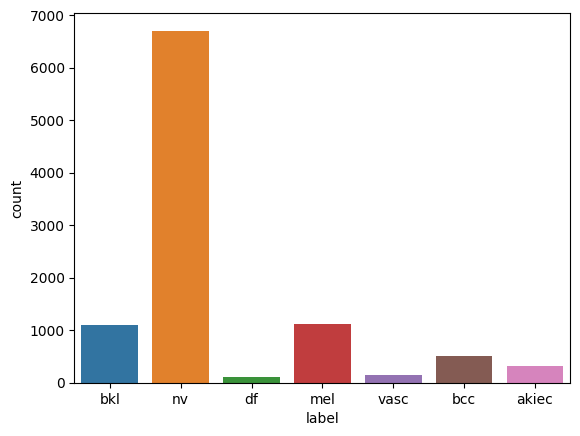

In [10]:
sns.countplot(x=df_labels['label'])
plt.show()

In [11]:
class_weights = class_weight.compute_class_weight('balanced', classes=class_names, y=df_labels['label'])
class_wt_dict = dict(enumerate(class_weights))
class_wt_dict

{0: 4.375273044997815,
 1: 2.78349082823791,
 2: 1.301832835044846,
 3: 12.440993788819876,
 4: 1.2854575792581184,
 5: 0.21338020666879728,
 6: 10.075452716297788}

# Using random data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [12]:
def get_augmentations(with_augmentations: bool) -> dict:
    result = {}

    if with_augmentations:
        result = {
            'horizontal_flip': True,
            'vertical_flip': True,
            'rotation_range': 30,
            'width_shift_range': 0.1,
            'height_shift_range': 0.1,
            'shear_range': 0.1,
            'zoom_range': 0.2,
            'fill_mode': 'nearest',
        }
    else:
        print('no augmentations')

    return result


data_augmentation = get_augmentations(config['with_augmentations'])

# Build a model

In [13]:
def get_model(name: str):
    inputs = {
        'weights': 'imagenet',  # load weights pre-trained on ImageNet
        'include_top': False,  # do not include the ImageNet classifier at the top
        'input_shape': TARGET_SIZE + (3,)
    }

    if name == 'ResNet50':
        _base_model = ResNet50(**inputs)
        _base_preprocess = tf.keras.applications.resnet50.preprocess_input
        _last_conv_layer_name = 'conv5_block3_out'
    elif name == 'InceptionResNetV2':
        _base_model = InceptionResNetV2(**inputs)
        _base_preprocess = tf.keras.applications.inception_resnet_v2.preprocess_input
        _last_conv_layer_name = 'conv_7b_ac'
    elif name == 'Xception':
        _base_model = Xception(**inputs)
        _base_preprocess = tf.keras.applications.xception.preprocess_input  # this model expects data in the range of (-1,1) and not (0,1)
        _last_conv_layer_name = 'block14_sepconv2_act'
    elif name == 'VGG19':
        _base_model = VGG19(**inputs)
        _base_preprocess = tf.keras.applications.vgg19.preprocess_input
        _last_conv_layer_name = 'block5_conv4'
    else:
        raise ValueError('Invalid model name')

    return _base_model, _base_preprocess, _last_conv_layer_name

In [14]:
base_model, base_preprocess, last_conv_layer_name = get_model(config['model_name'])
image_gen = ImageDataGenerator(preprocessing_function=base_preprocess, validation_split=0.15, **data_augmentation)

80134624/80134624 [==============================] - 0s 0us/step


### Train Test Split

In [15]:
flow_from_directory_args = {
    'directory': IMAGES_DIRECTORY,
    'target_size': TARGET_SIZE,
    'batch_size': BATCH_SIZE,
    'color_mode': 'rgb',
    'class_mode': 'categorical',
    'seed': SEED,
}

train_image_gen = image_gen.flow_from_directory(subset='training', **flow_from_directory_args)
test_image_gen = image_gen.flow_from_directory(subset='validation', shuffle=False, **flow_from_directory_args)
print(test_image_gen.class_indices)

Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [16]:
# save test_image_gen.classes to csv
pd.DataFrame(test_image_gen.classes).to_csv(Path(ROOT, DATA_PATH, 'test_image_gen_classes.csv'), index=False)

# save list(test_image_gen.class_indices.keys()) as csv
pd.DataFrame(list(test_image_gen.class_indices.keys())).to_csv(
    Path(ROOT, DATA_PATH, 'test_image_gen_class_indices.csv'), index=False)

<Axes: ylabel='count'>

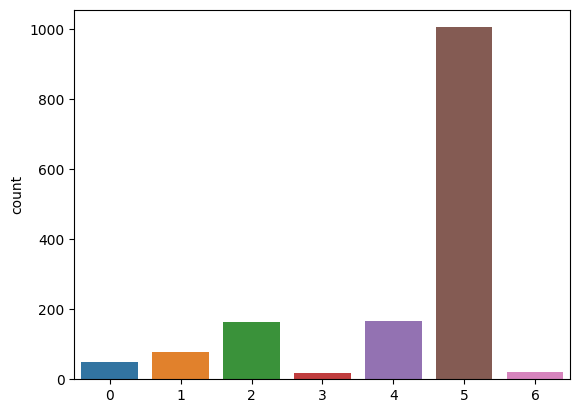

In [17]:
sns.countplot(x=test_image_gen.classes)

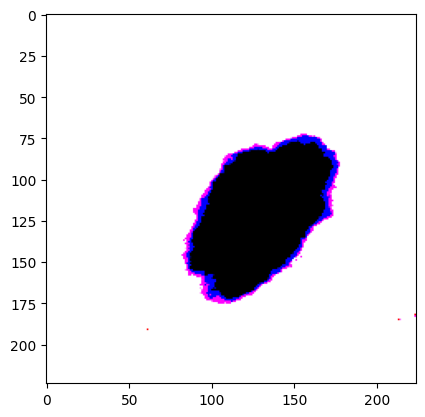

In [18]:
plt.imshow(train_image_gen[0][0][0])

In [19]:
for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, kernel_regularizer='l2', activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
optimizer = Adam(0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

csv_logger = CSVLogger(TRAINING_FILE, append=False)
model_chkpt = ModelCheckpoint(MODEL_PATH, save_best_only=True, save_weights_only=True, monitor='val_accuracy',
                              verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

callback_list = [csv_logger, model_chkpt, lr_reduce, early_stop]

## Model Training

In [22]:
if config['train_model']:
    history = model.fit(train_image_gen,
                        epochs=30,
                        validation_data=test_image_gen,
                        class_weight=class_wt_dict,
                        callbacks=callback_list
                        )

    log_data = pd.DataFrame(model.history.history)
    log_data.to_csv(TRAINING_FILE)
else:
    model.load_weights(MODEL_PATH)  # load weights
    log_data = pd.read_csv(TRAINING_FILE)  # load history

Epoch 1/30
134/134 [==============================] - ETA: 0s - loss: 4.9875 - accuracy: 0.0857
Epoch 1: val_accuracy improved from -inf to 0.08739, saving model to /content/drive/MyDrive/final_project/data/models/model-VGG19-rgb-aug.hdf5
134/134 [==============================] - 226s 2s/step - loss: 4.9875 - accuracy: 0.0857 - val_loss: 4.5070 - val_accuracy: 0.0874 - lr: 1.0000e-04
Epoch 2/30
134/134 [==============================] - ETA: 0s - loss: 4.1465 - accuracy: 0.3357
Epoch 2: val_accuracy improved from 0.08739 to 0.66244, saving model to /content/drive/MyDrive/final_project/data/models/model-VGG19-rgb-aug.hdf5
134/134 [==============================] - 213s 2s/step - loss: 4.1465 - accuracy: 0.3357 - val_loss: 3.8031 - val_accuracy: 0.6624 - lr: 1.0000e-04
Epoch 3/30
134/134 [==============================] - ETA: 0s - loss: 3.5373 - accuracy: 0.4594
Epoch 3: val_accuracy did not improve from 0.66244
134/134 [==============================] - 214s 2s/step - loss: 3.5373 - a

In [23]:
log_data

,loss,accuracy,val_loss,val_accuracy,lr
0,4.987493,0.085721,4.506956,0.087392,0.000100
1,4.146502,0.335721,3.803083,0.662442,0.000100
2,3.537318,0.459371,3.283885,0.609073,0.000100
3,3.093188,0.258924,2.911581,0.394263,0.000100
4,2.837068,0.232386,2.762149,0.558372,0.000050
5,2.700756,0.345585,2.634942,0.651101,0.000050
6,2.610936,0.452677,2.576551,0.631087,0.000025
7,2.554070,0.492015,2.521537,0.575717,0.000025
8,2.512641,0.396783,2.504140,0.204136,0.000012
9,2.486744,0.418037,2.465743,0.647098,0.000012


### Model Evaluation

<Axes: >

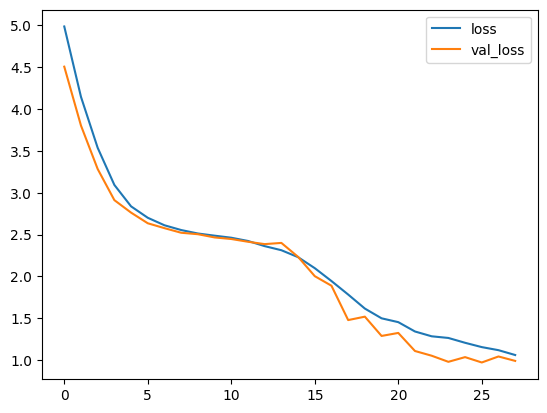

In [24]:
metrics = pd.DataFrame(log_data)
metrics[['loss', 'val_loss']].plot()

<Axes: >

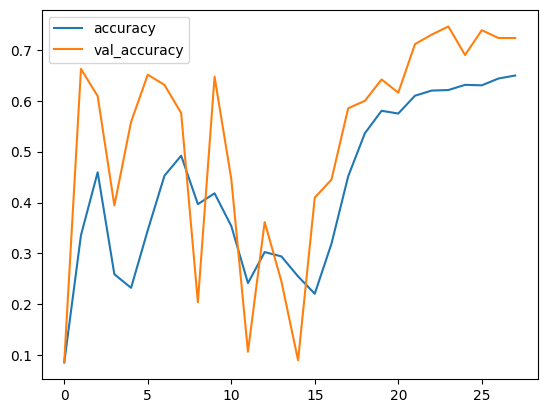

In [25]:
metrics[['accuracy', 'val_accuracy']].plot()

In [26]:
model.evaluate(test_image_gen)

24/24 [==============================] - 31s 1s/step - loss: 0.9829 - accuracy: 0.7218


[0.9829382300376892, 0.7218145728111267]

In [27]:
predictions = model.predict(test_image_gen, verbose=1)
# save predictions
np.save(PREDICTIONS_FILE, predictions)

24/24 [==============================] - 31s 1s/step


In [28]:
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes

## The confusion matrix
The confusion matrix can be used to evaluate the performance of a multi-class CNN classifier. By looking at the diagonal of the confusion matrix, you can see the percentage of instances that were correctly classified. You can also look at the off-diagonal elements of the confusion matrix to see which classes are being misclassified most often. This information can be used to improve the performance of the classifier by adjusting the hyperparameters or by using a different training algorithm.

In [29]:
conf_matrix = confusion_matrix(test_labels, predictions)

Normalized confusion matrix


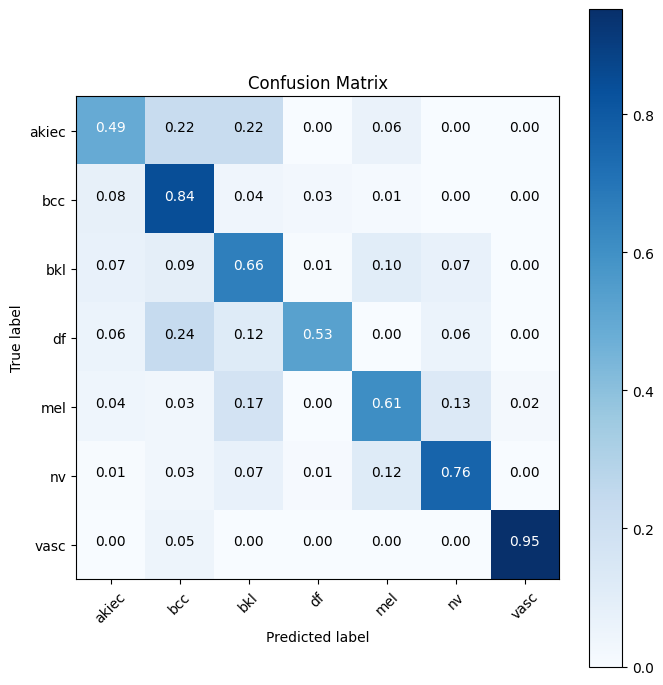

In [30]:
def plot_confusion_matrix(confusion_matrix, classes: list,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=cm.Blues) -> None:
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(7, 7))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = confusion_matrix.max() / 2.

    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if confusion_matrix[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


confusion_matrix_plot_labels = list(test_image_gen.class_indices.keys())
plot_confusion_matrix(conf_matrix, confusion_matrix_plot_labels, title='Confusion Matrix', normalize=True)

In [31]:
# Creating classification report
report = classification_report(test_image_gen.classes, predictions, zero_division=0)

print('Classification Report:')
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.49      0.46        49
           1       0.49      0.84      0.62        77
           2       0.48      0.66      0.55       164
           3       0.43      0.53      0.47        17
           4       0.42      0.61      0.50       166
           5       0.96      0.76      0.85      1005
           6       0.77      0.95      0.85        21

    accuracy                           0.73      1499
   macro avg       0.57      0.69      0.61      1499
weighted avg       0.80      0.73      0.75      1499



---
# GradCam

Grad-CAM, or Gradient-weighted Class Activation Mapping, is a technique for visualizing the parts of an image that are most relevant to a model's prediction. It works by taking the gradients of the model's output with respect to the input image, and then weighting these gradients by the activations of the last convolutional layer. The resulting heatmap can then be overlaid on the original image to show which parts of the image are most important for the model's prediction.

Grad-CAM is a useful tool for understanding how deep learning models work. It can be used to identify the features that a model is using to make its predictions, and to see how these features change when the model is presented with different images. Grad-CAM can also be used to debug models, and to identify areas where the model is making mistakes.

In [32]:
def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name: str, pred_index=None) -> np.ndarray:
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)

        if pred_index is None:
            pred_index = tf.argmax(preds[0])

        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()


def save_and_display_gradcam(img_path: str, heatmap, alpha=1.2) -> None:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (250, 250))
    img = img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap('viridis')
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img - 50
    superimposed_img = array_to_img(superimposed_img)

    return superimposed_img


def predict(image: str, _last_conv_layer_name: str) -> None:
    img_path = str(Path(IMAGES_DIRECTORY / f'{image}.jpg'))
    print('image:', image)
    img_array = base_preprocess(get_img_array(img_path, size=TARGET_SIZE))

    preds = model.predict(img_array)
    pred_index = np.argmax(preds)
    prediction = class_names[pred_index]
    print(f'prediction: {prediction}')
    print(f'probability: {round(preds[0][pred_index] * 100, 2)}%')

    # print class names and probabilities in descending order
    probs_dict = {class_names[i]: preds[0][i] for i in range(len(class_names))}
    probs_dict = {k: f'{round(v * 100, 2)}%' for k, v in
                  sorted(probs_dict.items(), key=lambda item: item[1], reverse=True)}
    print(probs_dict)

    heatmap = make_gradcam_heatmap(img_array, model, _last_conv_layer_name)

    image_titles = ['Lesion', 'Heatmap', 'Overlay']
    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(13, 4))

    lesion = cv2.imread(img_path)
    lesion = cv2.resize(lesion, (300, 300))
    lesion = cv2.cvtColor(lesion, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (10, 10))
    superimp = save_and_display_gradcam(img_path, heatmap)
    overlay_arr = [lesion, heatmap, superimp]

    for i, title in enumerate(image_titles):
        if i == 1:
            ax[i].set_title(title, fontsize=12)
            sns.heatmap(overlay_arr[i], ax=ax[i], cmap='viridis')
            continue

        ax[i].set_title(title, fontsize=12)
        ax[i].imshow(overlay_arr[i])
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

image: df/ISIC_0030321
1/1 [==============================] - 0s 424ms/step
prediction: bkl
probability: 32.08%
{'bkl': '32.08%', 'bcc': '20.96%', 'akiec': '19.68%', 'df': '14.12%', 'mel': '5.67%', 'nv': '4.79%', 'vasc': '2.69%'}


<ipython-input-32-dab118b41207>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('viridis')


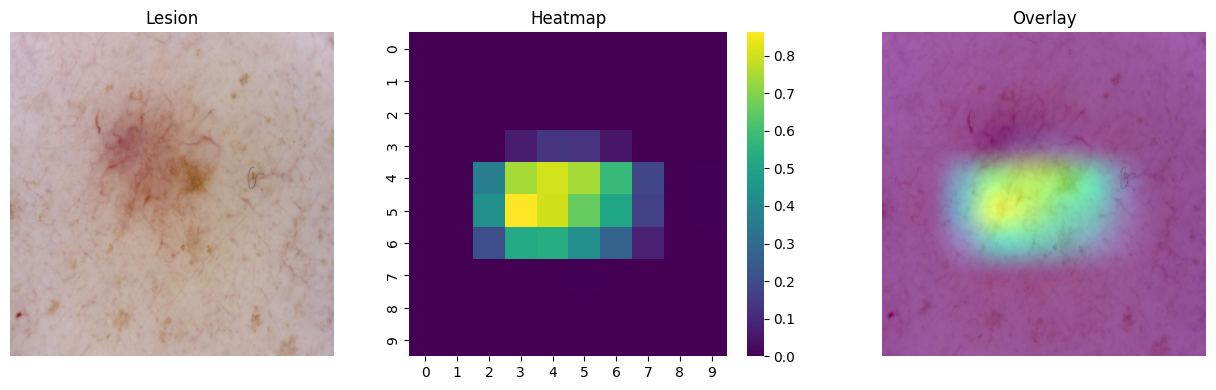

In [33]:
predict('df/ISIC_0030321', last_conv_layer_name)

image: mel/ISIC_0027622
1/1 [==============================] - 0s 19ms/step
prediction: mel
probability: 81.02%
{'mel': '81.02%', 'nv': '15.91%', 'bkl': '2.61%', 'akiec': '0.23%', 'df': '0.14%', 'bcc': '0.05%', 'vasc': '0.04%'}


<ipython-input-32-dab118b41207>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('viridis')


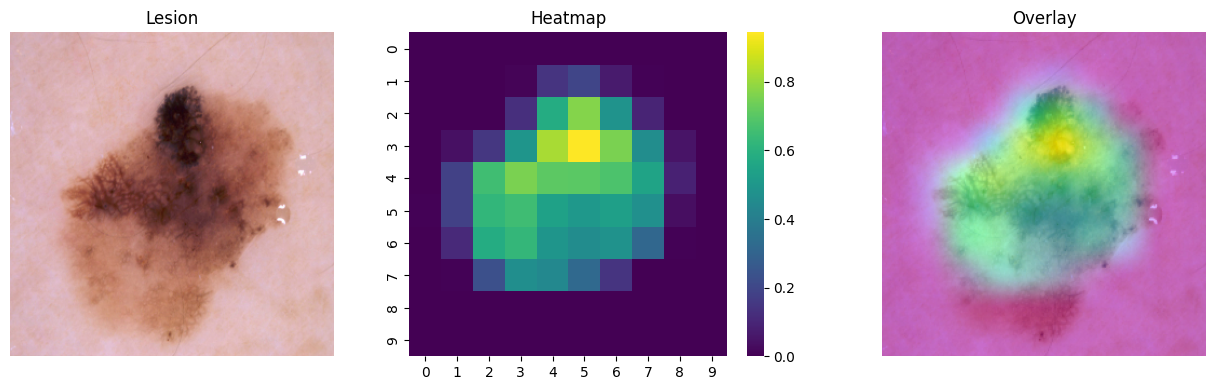

In [34]:
predict('mel/ISIC_0027622', last_conv_layer_name)

In [ ]:
predict('nv/ISIC_0024350', last_conv_layer_name)

image: nv/ISIC_0024350
1/1 [==============================] - 0s 21ms/step
prediction: nv
probability: 99.55%
{'nv': '99.55%', 'bkl': '0.23%', 'df': '0.11%', 'mel': '0.09%', 'vasc': '0.01%', 'bcc': '0.01%', 'akiec': '0.0%'}


In [ ]:
from google.colab import runtime
runtime.unassign()